In [ ]:
#Imports & path

from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score, f1_score
import joblib
from collections import defaultdict
import pyarrow as pa
import pyarrow.parquet as pq
from tqdm.notebook import tqdm
from sklearn.cluster import MiniBatchKMeans
from sklearn.model_selection import TimeSeriesSplit
import shap
import joblib
import warnings

warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

OUT_DIR = Path("../data/processed")
MODEL_DIR = Path("../models")
MODEL_DIR.mkdir(parents=True, exist_ok=True)

PARQUET = OUT_DIR / "vehicle_collisions_subset.parquet"
print("Parquet path:", PARQUET)

Parquet path: ..\data\processed\vehicle_collisions_subset.parquet


In [2]:
#Loading the cleaned data

df = pd.read_parquet(PARQUET)
print("Loaded rows,cols:", df.shape)
display(df.head())
print("Target distribution (severe):")
print(df['severe'].value_counts(normalize=True))


Loaded rows,cols: (2196754, 14)


,ts,date,hour,weekday,is_weekend,severe,LATITUDE,LONGITUDE,segment_id,BOROUGH,ZIP CODE,ON STREET NAME,CROSS STREET NAME,COLLISION_ID
0,2021-09-11 02:39:00,2021-09-11,2,5,1,1,NaN,NaN,None,None,None,WHITESTONE EXPRESSWAY,20 AVENUE,4455765
1,2022-03-26 11:45:00,2022-03-26,11,5,1,1,NaN,NaN,None,None,None,QUEENSBORO BRIDGE UPPER,None,4513547
2,2023-11-01 01:29:00,2023-11-01,1,2,0,1,40.62179,-73.970024,40.6218_-73.97,BROOKLYN,11230,OCEAN PARKWAY,AVENUE K,4675373
3,2022-06-29 06:55:00,2022-06-29,6,2,0,0,NaN,NaN,None,None,None,THROGS NECK BRIDGE,None,4541903
4,2022-09-21 13:21:00,2022-09-21,13,2,0,0,NaN,NaN,None,None,None,BROOKLYN BRIDGE,None,4566131


Target distribution (severe):
severe
0    0.758859
1    0.241141
Name: proportion, dtype: float64


In [3]:
OUT_DIR = Path("../data/processed")
PARQUET = OUT_DIR / "vehicle_collisions_subset.parquet"
print("Loading", PARQUET)
df = pd.read_parquet(PARQUET)
print("Loaded rows,cols:", df.shape)

df['ts'] = pd.to_datetime(df['ts'])

df_time = df.sort_values('ts').copy()

if 'LATITUDE' in df_time.columns and 'LONGITUDE' in df_time.columns:
    df_geo = df_time.dropna(subset=['LATITUDE','LONGITUDE']).copy()
else:
    raise RuntimeError("LATITUDE / LONGITUDE columns missing in parquet. Re-run Day2 EDA to create them.")

lat_min, lat_max = 40.4774, 40.9176
lon_min, lon_max = -74.2591, -73.7004
mask_valid_nyc = (
    df_geo['LATITUDE'].between(lat_min, lat_max) &
    df_geo['LONGITUDE'].between(lon_min, lon_max)
)
df_geo_clean = df_geo[mask_valid_nyc].copy()
print("Rows with geo coords before filter:", len(df_geo), "after:", len(df_geo_clean))

if 'segment_id' not in df_geo_clean.columns:
    PRECISION = 4
    df_geo_clean['lat_round'] = df_geo_clean['LATITUDE'].round(PRECISION)
    df_geo_clean['lon_round'] = df_geo_clean['LONGITUDE'].round(PRECISION)
    df_geo_clean['segment_id'] = df_geo_clean['lat_round'].astype(str) + "_" + df_geo_clean['lon_round'].astype(str)

print("Unique segments (approx):", df_geo_clean['segment_id'].nunique())
df_geo_clean.head()

Loading ..\data\processed\vehicle_collisions_subset.parquet
Loaded rows,cols: (2196754, 14)
Rows with geo coords before filter: 1956597 after: 1950503
Unique segments (approx): 224155


,ts,date,hour,weekday,is_weekend,severe,LATITUDE,LONGITUDE,segment_id,BOROUGH,ZIP CODE,ON STREET NAME,CROSS STREET NAME,COLLISION_ID
2103302,2012-07-01 00:05:00,2012-07-01,0,6,1,0,40.762127,-73.997387,40.7621_-73.9974,MANHATTAN,10036,11 AVENUE,WEST 44 STREET,37632
2099258,2012-07-01 00:05:00,2012-07-01,0,6,1,1,40.697753,-73.813916,40.6978_-73.8139,None,None,None,None,2999940
2102894,2012-07-01 00:10:00,2012-07-01,0,6,1,0,40.588868,-73.972745,40.5889_-73.9727,BROOKLYN,11223,WEST 3 STREET,BOUCK COURT,116256
2101690,2012-07-01 00:10:00,2012-07-01,0,6,1,1,40.733610,-73.923840,40.7336_-73.9238,None,None,None,None,3044659
2099879,2012-07-01 00:20:00,2012-07-01,0,6,1,0,40.677406,-73.983048,40.6774_-73.983,BROOKLYN,11215,4 AVENUE,UNION STREET,175808


In [4]:
# Ensure needed columns exist
assert 'ts' in df.columns, "ts missing; load the Day2 parquet instead."

# ensure numeric features types
df['hour'] = df['hour'].astype(int)
df['weekday'] = df['weekday'].astype(int)
df['is_weekend'] = df['is_weekend'].astype(int)

if 'segment_id' not in df.columns:
    PRECISION = 4
    df['segment_id'] = (df['LATITUDE'].round(PRECISION).astype(str) + "_" +
                        df['LONGITUDE'].round(PRECISION).astype(str))

FEATURES = ['hour','weekday','is_weekend','segment_id','BOROUGH']
TARGET = 'severe'

df = df.dropna(subset=[TARGET]).copy()
print("Using features:", FEATURES)

Using features: ['hour', 'weekday', 'is_weekend', 'segment_id', 'BOROUGH']


In [5]:
# 80% train / 20% test by time order, sorted by ts
df = df.sort_values('ts').reset_index(drop=True)
split_idx = int(0.8 * len(df))  
train = df.iloc[:split_idx].copy()
test  = df.iloc[split_idx:].copy()

# Align ts to hourly window for history merge
train['window_start'] = train['ts'].dt.floor('h')
test['window_start']  = test['ts'].dt.floor('h')

print("Train rows:", len(train), "Test rows:", len(test))
print("Train date range:", train['ts'].min(), "->", train['ts'].max())
print("Test  date range:", test['ts'].min(), "->", test['ts'].max())

Train rows: 1757403 Test rows: 439351
Train date range: 2012-07-01 00:05:00 -> 2021-02-20 11:00:00
Test  date range: 2021-02-20 11:08:00 -> 2025-08-05 23:30:00


In [6]:
cat_cols = [c for c in FEATURES if c not in ['hour','weekday','is_weekend']]
encoders = {}

TOP_K = 5000   
high_cardinality_map = {"segment_id": TOP_K}  

for c in cat_cols:
    print("Encoding:", c)
    train_vals = train[c].fillna('UNK').astype(str)
    if c in high_cardinality_map:
        k = high_cardinality_map[c]
        topk = set(train_vals.value_counts().nlargest(k).index)
        train_reduced = train_vals.where(train_vals.isin(topk), other='OTHER')
    else:
        train_reduced = train_vals

    unique_classes = train_reduced.unique().tolist()
    if 'UNK' not in unique_classes:
        unique_classes.append('UNK')
    if 'OTHER' in unique_classes and 'OTHER' not in unique_classes:
        unique_classes.append('OTHER')

    mapping = {val: idx for idx, val in enumerate(unique_classes)}
    encoders[c] = {"mapping": mapping, "classes": unique_classes}

    train[c] = train_reduced.map(mapping).astype(int)

    test_vals = test[c].fillna('UNK').astype(str)
    if c in high_cardinality_map:
        test_vals = test_vals.where(test_vals.isin(topk), other='OTHER')

    test[c] = test_vals.map(mapping).fillna(mapping['UNK']).astype(int)

    print(f"  -> {len(mapping)} classes (train-encoded).")

X_train = train[FEATURES]
y_train = train[TARGET]
X_test  = test[FEATURES]
y_test  = test[TARGET]

print("X_train shape:", X_train.shape, "X_test shape:", X_test.shape)

Encoding: segment_id
  -> 5001 classes (train-encoded).
Encoding: BOROUGH
  -> 6 classes (train-encoded).
X_train shape: (1757403, 5) X_test shape: (439351, 5)


In [7]:
#Training the LightGBM baseline

lgb_train = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_cols, free_raw_data=False)
lgb_test  = lgb.Dataset(X_test,  label=y_test,  reference=lgb_train,  free_raw_data=False)

params = {
    'objective': 'binary',
    'metric': ['auc','binary_logloss'],
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'verbose': -1
}

model = lgb.train(params, lgb_train, valid_sets=[lgb_train, lgb_test], num_boost_round=1000)

In [8]:
#Evaluation metrics

y_pred_prob = model.predict(X_test, num_iteration=model.best_iteration)

roc = roc_auc_score(y_test, y_pred_prob)
pr  = average_precision_score(y_test, y_pred_prob)
print("ROC-AUC:", roc)
print("PR-AUC (avg precision):", pr)

k = 0.05
n_top = max(1, int(k * len(y_pred_prob)))
top_idx = np.argsort(y_pred_prob)[-n_top:]
precision_at_k = y_test.iloc[top_idx].mean()
print(f"Precision@{int(k*100)}%: {precision_at_k:.4f}")

ROC-AUC: 0.5398054628011004
PR-AUC (avg precision): 0.4423692475966587
Precision@5%: 0.5227


In [9]:
imp = pd.DataFrame({
    'feature': model.feature_name(),
    'importance': model.feature_importance(importance_type='gain')
}).sort_values('importance', ascending=False)
display(imp.head(20))

,feature,importance
3,segment_id,465154.215250
0,hour,131476.012059
4,BOROUGH,69651.276028
1,weekday,20076.463642
2,is_weekend,128.137260


In [10]:
MODEL_DIR.mkdir(exist_ok=True)
joblib.dump(model, MODEL_DIR / "lgb_baseline_model.joblib")
joblib.dump(encoders, MODEL_DIR / "label_encoders.joblib")
print("Saved model & encoders to", MODEL_DIR)

Saved model & encoders to ..\models


In [11]:
prevalence = y_test.mean()
print("Prevalence in test:", prevalence, f"({prevalence:.2%})")

k = 0.05
n_top = max(1, int(k * len(y_pred_prob)))
top_idx = np.argsort(y_pred_prob)[-n_top:]
model_prec_at_k = y_test.iloc[top_idx].mean()
print(f"Model precision@{int(k*100)}%:", model_prec_at_k)

print("Random baseline precision@k ~= prevalence:", prevalence)

hist_rate = train.groupby('segment_id')['severe'].mean()
test_seg_rate = test['segment_id'].map(hist_rate).fillna(prevalence)
top_idx_hist = np.argsort(test_seg_rate.values)[-n_top:]
hist_prec_at_k = y_test.iloc[top_idx_hist].mean()
print(f"Historical-seg precision@{int(k*100)}%:", hist_prec_at_k)

Prevalence in test: 0.4018017484881109 (40.18%)
Model precision@5%: 0.5226931306049984
Random baseline precision@k ~= prevalence: 0.4018017484881109
Historical-seg precision@5%: 0.541403013611326


In [12]:
df_all = df_time.sort_values('ts').reset_index(drop=True)   
split_idx = int(0.8 * len(df_all))
train = df_all.iloc[:split_idx].copy()
test  = df_all.iloc[split_idx:].copy()
print("Train rows:", len(train), "Test rows:", len(test))
print("Train range:", train['ts'].min(), "->", train['ts'].max())
print("Test range: ", test['ts'].min(), "->", test['ts'].max())

Train rows: 1757403 Test rows: 439351
Train range: 2012-07-01 00:05:00 -> 2021-02-20 11:00:00
Test range:  2021-02-20 11:08:00 -> 2025-08-05 23:30:00


In [13]:
HIST_DIR = Path("../data/processed/segment_history_files")
files = sorted(HIST_DIR.glob("*.parquet"))
print("History folder:", HIST_DIR)
print("Files found:", len(files))

total_bytes = sum(f.stat().st_size for f in files)
print("Total history size (GB):", round(total_bytes / 2**30, 3))
print("Example files (first 10):")
for f in files[:10]:
    print(" -", f.name, round(f.stat().st_size / 2**20, 3), "MB")

# load a single file as a sanity check
if files:
    sample = pd.read_parquet(files[0])
    display(sample.head())
    print("Sample shape:", sample.shape)
else:
    print("No history files found in folder. If you haven't run the writer, run the writer cell first.")


History folder: ..\data\processed\segment_history_files
Files found: 0
Total history size (GB): 0.0
Example files (first 10):
No history files found in folder. If you haven't run the writer, run the writer cell first.


In [14]:
NEW_HIST_DIR = Path("../data/processed/segment_history_files_shifted_v2")
NEW_HIST_DIR.mkdir(parents=True, exist_ok=True)

TOP_N = 5000
top_segments = df_geo_clean['segment_id'].value_counts().nlargest(TOP_N).index.tolist()

for seg in tqdm(top_segments):
    seg_rows = df_geo_clean[df_geo_clean['segment_id'] == seg]
    if seg_rows.empty:
        continue
    seg_ts = seg_rows.set_index('ts').sort_index()
    start = seg_ts.index.min().floor('h')
    end   = seg_ts.index.max().ceil('h')
    if pd.isna(start) or pd.isna(end):
        continue
    idx = pd.date_range(start=start, end=end, freq='h')

    sev_hourly = seg_ts['severe'].resample('h').sum().reindex(idx, fill_value=0)
    tot_hourly = seg_ts['severe'].resample('h').count().reindex(idx, fill_value=0)

    sev_prev = sev_hourly.shift(1).fillna(0).astype(int)

    tmp = pd.DataFrame({
        'segment_id': [seg] * len(idx),
        'sev_1h': sev_prev,
        'sev_6h': sev_hourly.rolling(6).sum().fillna(0).astype(int),
        'sev_24h': sev_hourly.rolling(24).sum().fillna(0).astype(int),
        'tot_1h': tot_hourly.rolling(1).sum().fillna(0).astype(int),
        'tot_6h': tot_hourly.rolling(6).sum().fillna(0).astype(int),
        'tot_24h': tot_hourly.rolling(24).sum().fillna(0).astype(int),
    }, index=idx)

    tmp = tmp.reset_index().rename(columns={'index': 'window_start'})

    safe_name = str(seg).replace("/", "_").replace("\\", "_").replace(" ", "_")[:200]
    out_path = NEW_HIST_DIR / f"{safe_name}.parquet"
    tmp.to_parquet(out_path, index=False, compression='snappy')

  0%|          | 0/5000 [00:00<?, ?it/s]

In [15]:
def merge_and_write_fast(df_split, out_parquet_path, hist_dir=HIST_DIR, hist_cols=None, batch_size=1000):
    if hist_cols is None:
        hist_cols = ['sev_1h','sev_6h','sev_24h','tot_1h','tot_6h','tot_24h']

    df_split = df_split.copy()
    df_split['segment_id'] = df_split['segment_id'].fillna('UNK').astype(str)
    df_split['window_start'] = pd.to_datetime(df_split['ts']).dt.floor('h')

    unique_segs = df_split['segment_id'].unique().tolist()
    writer = None

    for i in range(0, len(unique_segs), batch_size):
        batch_segs = unique_segs[i:i+batch_size]
        batch_df = df_split[df_split['segment_id'].isin(batch_segs)].copy()

        hist_dfs = []
        for seg in batch_segs:
            safe_name = seg.replace("/", "_").replace("\\", "_").replace(" ", "_")
            hf_path = hist_dir / f"{safe_name}.parquet"
            if hf_path.exists():
                hf = pd.read_parquet(hf_path)
                hf['segment_id'] = str(seg)
                hf['window_start'] = pd.to_datetime(hf['window_start'])
                hist_dfs.append(hf)

        if hist_dfs:
            hist_all = pd.concat(hist_dfs, ignore_index=True)
            merged = batch_df.merge(hist_all, on=['segment_id', 'window_start'], how='left')
        else:
            merged = batch_df.copy()

        for c in hist_cols:
            if c not in merged.columns:
                merged[c] = 0
            merged[c] = merged[c].fillna(0).astype(int)
        merged = merged.reset_index(drop=True)

        table = pa.Table.from_pandas(merged, preserve_index=False)
        if writer is None:
            writer = pq.ParquetWriter(str(out_parquet_path), table.schema)
        writer.write_table(table)

    if writer is not None:
        writer.close()
    else:
        raise RuntimeError("No data written in merge_and_write_fast.")


OUT_MERGED = Path("../data/processed")
merge_and_write_fast(train, OUT_MERGED / "train_with_hist_shifted_v2.parquet")
merge_and_write_fast(test,  OUT_MERGED / "test_with_hist_shifted_v2.parquet")


In [16]:
train_s = pd.read_parquet("../data/processed/train_with_hist_shifted_v2.parquet")
test_s  = pd.read_parquet("../data/processed/test_with_hist_shifted_v2.parquet")

for df, name in [(train_s, "train_shifted_v2"), (test_s, "test_shifted_v2")]:
    total = len(df)
    n_sev1 = (df['sev_1h'] > 0).sum()
    n_severe = df['severe'].sum()
    prop = df.loc[df['sev_1h']>0, 'severe'].mean() if n_sev1>0 else np.nan
    prop2 = df.loc[df['severe']==1, 'sev_1h'].gt(0).mean() if n_severe>0 else np.nan
    print(f"=== {name} ===")
    print("rows:", total)
    print("rows with sev_1h>0:", n_sev1, f"({n_sev1/total:.2%})")
    print("rows with severe==1:", n_severe, f"({n_severe/total:.2%})")
    print("P(severe=1 | sev_1h>0):", prop)
    print("P(sev_1h>0 | severe=1):", prop2)
    print()


=== train_shifted_v2 ===
rows: 1757403
rows with sev_1h>0: 0 (0.00%)
rows with severe==1: 353195 (20.10%)
P(severe=1 | sev_1h>0): nan
P(sev_1h>0 | severe=1): 0.0

=== test_shifted_v2 ===
rows: 439351
rows with sev_1h>0: 0 (0.00%)
rows with severe==1: 176532 (40.18%)
P(severe=1 | sev_1h>0): nan
P(sev_1h>0 | severe=1): 0.0



Using numeric features: ['hour', 'weekday', 'is_weekend', 'LATITUDE', 'LONGITUDE', 'sev_1h', 'sev_6h', 'sev_24h', 'tot_1h', 'tot_6h', 'tot_24h']
X_train shape: (1757403, 11) X_test shape: (439351, 11)
Training until validation scores don't improve for 50 rounds
[50]	training's binary_logloss: 0.494897	training's auc: 0.583769	valid_1's binary_logloss: 0.770365	valid_1's auc: 0.524496
[100]	training's binary_logloss: 0.494082	training's auc: 0.587437	valid_1's binary_logloss: 0.769907	valid_1's auc: 0.527111
[150]	training's binary_logloss: 0.493612	training's auc: 0.589974	valid_1's binary_logloss: 0.769651	valid_1's auc: 0.528731
[200]	training's binary_logloss: 0.493281	training's auc: 0.591753	valid_1's binary_logloss: 0.769491	valid_1's auc: 0.529584
[250]	training's binary_logloss: 0.492958	training's auc: 0.593537	valid_1's binary_logloss: 0.769315	valid_1's auc: 0.530492
[300]	training's binary_logloss: 0.492673	training's auc: 0.595047	valid_1's binary_logloss: 0.769184	valid_1

<Figure size 1000x600 with 0 Axes>

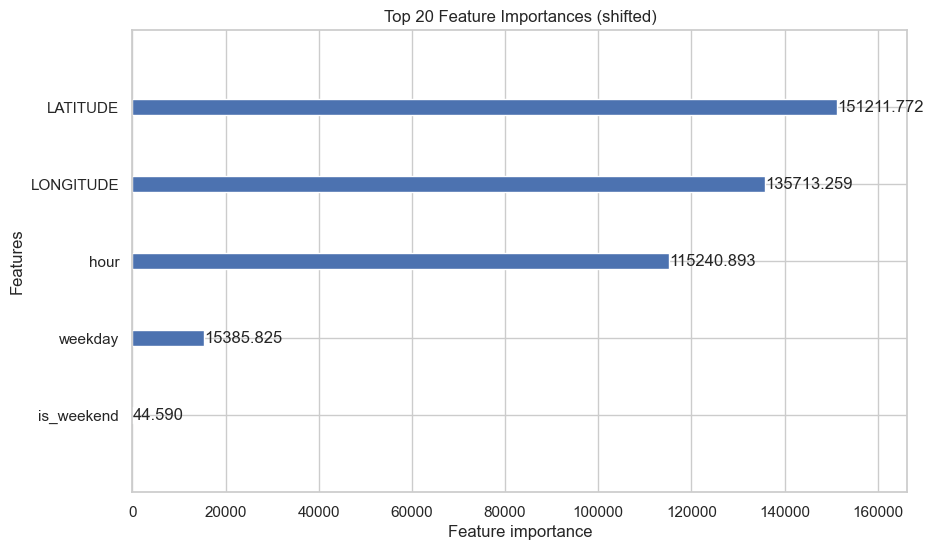

In [17]:
train = pd.read_parquet("../data/processed/train_with_hist_shifted_v2.parquet")
test  = pd.read_parquet("../data/processed/test_with_hist_shifted_v2.parquet")

target = "severe"
drop_cols = ["ts","date","segment_id","BOROUGH","ZIP CODE","ON STREET NAME","CROSS STREET NAME","COLLISION_ID","window_start"]

train[target] = train[target].astype(int)
test[target]  = test[target].astype(int)

numeric_cols = train.select_dtypes(include=[np.number]).columns.tolist()
numeric_feats = [c for c in numeric_cols if c != target and c not in drop_cols]

X_train = train[numeric_feats]
y_train = train[target]
X_test  = test[numeric_feats]
y_test  = test[target]

print("Using numeric features:", numeric_feats)
print("X_train shape:", X_train.shape, "X_test shape:", X_test.shape)

train_data = lgb.Dataset(X_train, label=y_train)
test_data  = lgb.Dataset(X_test, label=y_test, reference=train_data)

params = {
    "objective": "binary",
    "metric": ["binary_logloss", "auc"],
    "boosting_type": "gbdt",
    "learning_rate": 0.05,
    "num_leaves": 31,
    "max_depth": -1,
    "verbose": -1,
    "seed": 42,
}

callbacks = [lgb.callback.early_stopping(50), lgb.callback.log_evaluation(period=50)]

bst = lgb.train(params, train_data, num_boost_round=1000, valid_sets=[train_data, test_data], callbacks=callbacks)

best_iter = bst.best_iteration if getattr(bst, "best_iteration", None) else None
y_pred_prob = bst.predict(X_test, num_iteration=best_iter)
y_pred = (y_pred_prob >= 0.5).astype(int)

acc = accuracy_score(y_test, y_pred)
f1  = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_prob)

print(f"Accuracy: {acc:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")

prevalence = y_test.mean()
k = 0.05
n_top = max(1, int(k * len(y_pred_prob)))
top_idx = np.argsort(y_pred_prob)[-n_top:]
model_prec_at_k = y_test.iloc[top_idx].mean()

hist_rate = train.groupby('segment_id')['severe'].mean()
test_seg_rate = test['segment_id'].map(hist_rate).fillna(prevalence)
top_idx_hist = np.argsort(test_seg_rate.values)[-n_top:]
hist_prec_at_k = y_test.iloc[top_idx_hist].mean()

print("Prevalence (test):", prevalence)
print(f"Model precision@{int(k*100)}%: {model_prec_at_k:.4f}")
print(f"Historical-seg precision@{int(k*100)}%: {hist_prec_at_k:.4f}")

plt.figure(figsize=(10,6))
lgb.plot_importance(bst, max_num_features=20, importance_type="gain", figsize=(10,6))
plt.title("Top 20 Feature Importances (shifted)")
plt.show()

In [18]:
train_j = pd.read_parquet("../data/processed/train_with_hist_shifted_v2.parquet")
test_j  = pd.read_parquet("../data/processed/test_with_hist_shifted_v2.parquet")

for df, name in [(train_j, "train"), (test_j, "test")]:
    total = len(df)
    n_sev1 = (df['sev_1h'] > 0).sum()
    n_severe = df['severe'].sum()
    prop = df.loc[df['sev_1h']>0, 'severe'].mean() if n_sev1>0 else np.nan
    prop2 = df.loc[df['severe']==1, 'sev_1h'].gt(0).mean() if n_severe>0 else np.nan
    print(f"=== {name} ===")
    print("rows:", total)
    print("rows with sev_1h>0:", n_sev1, f"({n_sev1/total:.2%})")
    print("rows with severe==1:", n_severe, f"({n_severe/total:.2%})")
    print("P(severe=1 | sev_1h>0):", prop)
    print("P(sev_1h>0 | severe=1):", prop2)
    print()

=== train ===
rows: 1757403
rows with sev_1h>0: 0 (0.00%)
rows with severe==1: 353195 (20.10%)
P(severe=1 | sev_1h>0): nan
P(sev_1h>0 | severe=1): 0.0

=== test ===
rows: 439351
rows with sev_1h>0: 0 (0.00%)
rows with severe==1: 176532 (40.18%)
P(severe=1 | sev_1h>0): nan
P(sev_1h>0 | severe=1): 0.0



In [19]:
train = pd.read_parquet("../data/processed/train_with_hist_shifted_v2.parquet")
test  = pd.read_parquet("../data/processed/test_with_hist_shifted_v2.parquet")

train = train.sort_values("ts").reset_index(drop=True)

global_mean = train['severe'].mean()

grp = train.groupby('segment_id')['severe']
train['seg_count_so_far'] = grp.cumcount()
train['seg_sum_so_far']   = grp.cumsum() - train['severe']           
train['seg_mean_so_far']  = train['seg_sum_so_far'] / train['seg_count_so_far'].replace(0, np.nan)

k = 10.0
train['seg_te_smoothed'] = (train['seg_mean_so_far'] * train['seg_count_so_far'] + global_mean * k) / (train['seg_count_so_far'] + k)
train['seg_te_smoothed'] = train['seg_te_smoothed'].fillna(global_mean)

agg = train.groupby('segment_id').agg(n=('severe','count'), s=('severe','sum'))
agg['mean'] = agg['s'] / agg['n']
agg['te_smoothed'] = (agg['mean'] * agg['n'] + global_mean * k) / (agg['n'] + k)
seg_te_map = agg['te_smoothed'].to_dict()

train['seg_te'] = train['seg_te_smoothed']
test['seg_te']  = test['segment_id'].map(seg_te_map).fillna(global_mean)

train = train.drop(columns=['seg_count_so_far','seg_sum_so_far','seg_mean_so_far','seg_te_smoothed'])
display(train[['segment_id','seg_te']].head())

,segment_id,seg_te
0,40.7621_-73.9974,0.200976
1,40.6978_-73.8139,0.200976
2,40.5889_-73.9727,0.200976
3,40.7336_-73.9238,0.200976
4,40.6774_-73.983,0.200976


In [20]:
def add_cyclical(df):
    df['hour'] = pd.to_datetime(df['ts']).dt.hour
    df['hour_sin'] = np.sin(2*np.pi*df['hour']/24)
    df['hour_cos'] = np.cos(2*np.pi*df['hour']/24)
    df['weekday'] = pd.to_datetime(df['ts']).dt.weekday
    df['weekday_sin'] = np.sin(2*np.pi*df['weekday']/7)
    df['weekday_cos'] = np.cos(2*np.pi*df['weekday']/7)
    return df

train = add_cyclical(train)
test  = add_cyclical(test)

In [21]:
coords = train[['LATITUDE','LONGITUDE']].dropna()
k = 200
kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=10000)
kmeans.fit(coords)
train['cluster'] = kmeans.predict(train[['LATITUDE','LONGITUDE']].fillna(0))
test['cluster']  = kmeans.predict(test[['LATITUDE','LONGITUDE']].fillna(0))

cluster_agg = train.groupby('cluster')['severe'].agg(['count','mean'])


In [22]:
tscv = TimeSeriesSplit(n_splits=5)
params = {
    "objective":"binary",
    "metric":"auc",
    "boosting_type":"gbdt",
    "seed":42,
    "verbosity":-1
}

X = train[numeric_feats + ['seg_te']]
y = train['severe'].astype(int)

aucs = []
for fold, (tr_idx, val_idx) in enumerate(tscv.split(X)):
    X_tr, X_val = X.iloc[tr_idx], X.iloc[val_idx]
    y_tr, y_val = y.iloc[tr_idx], y.iloc[val_idx]
    dtr = lgb.Dataset(X_tr, label=y_tr)
    dval = lgb.Dataset(X_val, label=y_val, reference=dtr)
    bst = lgb.train({**params, "learning_rate":0.05, "num_leaves":31},
                    dtr, num_boost_round=500, valid_sets=[dval]
                     )
    yv = bst.predict(X_val, num_iteration=bst.best_iteration)
    auc_fold = roc_auc_score(y_val, yv)
    print("Fold", fold, "AUC:", auc_fold)
    aucs.append(auc_fold)
print("Mean CV AUC:", np.mean(aucs))

Fold 0 AUC: 0.5974784240207055
Fold 1 AUC: 0.5890002097170589
Fold 2 AUC: 0.5968286822755109
Fold 3 AUC: 0.6088999062365742
Fold 4 AUC: 0.6050808647102439
Mean CV AUC: 0.5994576173920187


Precision@5%: 0.47075158191833205


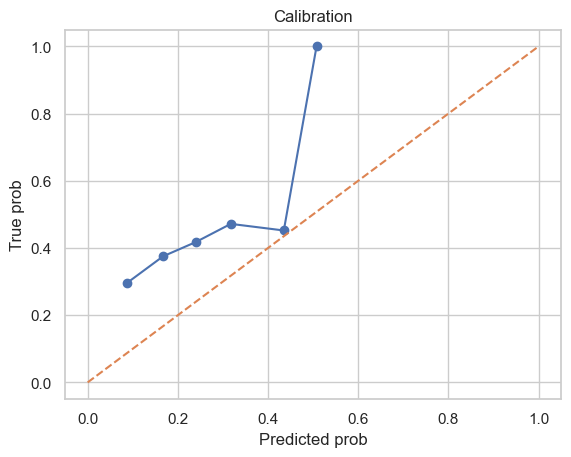

In [23]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

k = 0.05
n_top = max(1, int(k * len(y_pred_prob)))
top_idx = np.argsort(y_pred_prob)[-n_top:]
print("Precision@5%:", y_test.iloc[top_idx].mean())

prob_true, prob_pred = calibration_curve(y_test, y_pred_prob, n_bins=10)
plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0,1],[0,1], linestyle='--')
plt.xlabel("Predicted prob")
plt.ylabel("True prob")
plt.title("Calibration")
plt.show()


In [ ]:
FIG_DIR = Path("../figures"); FIG_DIR.mkdir(parents=True, exist_ok=True)
TEST_PARQUET = Path("../data/processed/test_with_hist_shifted_v2.parquet")
MODEL_PATH = Path("../models/lgb_baseline_model.joblib")

if not MODEL_PATH.exists():
    raise FileNotFoundError(f"Model not found: {MODEL_PATH}")

loaded = joblib.load(MODEL_PATH)
if isinstance(loaded, lgb.basic.Booster):
    booster = loaded
elif hasattr(loaded, "booster_") and isinstance(loaded.booster_, lgb.basic.Booster):
    booster = loaded.booster_
else:
    raise RuntimeError("Model file does not contain a LightGBM Booster object.")

print("Loaded booster. Booster feature names (in training order):")
model_feats = booster.feature_name()
print(model_feats)
print("Num features in booster:", len(model_feats))

df_test = pd.read_parquet(TEST_PARQUET)
DROP_COLS = ["ts","date","segment_id","BOROUGH","ZIP CODE","ON STREET NAME","CROSS STREET NAME","COLLISION_ID","window_start"]
TARGET = "severe"
features_all = [c for c in df_test.columns if c not in DROP_COLS + [TARGET]]
X_test = df_test[features_all].copy()
y_test = df_test[TARGET].astype(int).copy()
print("X_test current columns (count):", len(X_test.columns))

# Build a sample for SHAP 
n_pos_req, n_neg_req = 500, 500
if (y_test==1).sum()>0 and (y_test==0).sum()>0:
    npos = min(n_pos_req, int((y_test==1).sum()))
    nneg = min(n_neg_req, int((y_test==0).sum()))
    pos = X_test[y_test==1].sample(n=npos, random_state=42)
    neg = X_test[y_test==0].sample(n=nneg, random_state=42)
    X_sample = pd.concat([pos, neg]).sample(frac=1, random_state=42)
else:
    X_sample = X_test.sample(frac=min(0.05, 2000/len(X_test)), random_state=42)
print("SHAP sample shape:", X_sample.shape)

# Align X_sample to model features
sample_cols = list(X_sample.columns)
model_set = list(model_feats)
sample_set = list(sample_cols)

missing = [f for f in model_set if f not in sample_set]
extra   = [f for f in sample_set if f not in model_set]

if missing:
    print(f"WARNING: model expects {len(missing)} feature(s) not present in X_sample. Filling them with zeros: {missing}")
    for f in missing:
        X_sample[f] = 0

if extra:
    print(f"INFO: X_sample has {len(extra)} extra feature(s) not used by model. Dropping them: {extra[:20]}{('...' if len(extra)>20 else '')}")

# Reorder exactly in model order
X_sample_aligned = X_sample[model_set].copy()

print("Aligned X_sample shape:", X_sample_aligned.shape)

# Now compute SHAP
try:
    expl = shap.TreeExplainer(booster)
    svals = expl.shap_values(X_sample_aligned)
    shap_for_pos = svals[1] if isinstance(svals, (list, tuple)) else svals
    print("SHAP values computed with TreeExplainer(booster).")
except Exception as e:
    raise RuntimeError("SHAP computation failed: " + str(e))

# Summary beeswarm
plt.figure(figsize=(10,6))
try:
    shap.summary_plot(shap_for_pos, X_sample_aligned, show=False)
except Exception:
    shap_obj = shap.Explanation(values=shap_for_pos, data=X_sample_aligned, feature_names=list(X_sample_aligned.columns))
    shap.plots.beeswarm(shap_obj)
out_sum = FIG_DIR / "shap_summary_beeswarm_aligned.png"
plt.tight_layout()
plt.savefig(out_sum, dpi=200, bbox_inches="tight")
plt.close()
print("Saved SHAP summary:", out_sum)

# Dependence plot for seg_te 
feat = "seg_te" if "seg_te" in X_sample_aligned.columns else ("sev_1h" if "sev_1h" in X_sample_aligned.columns else X_sample_aligned.columns[0])
plt.figure(figsize=(8,6))
try:
    shap.dependence_plot(feat, shap_for_pos, X_sample_aligned, show=False)
except Exception:
    try:
        shap.plots.scatter(shap.Explanation(values=shap_for_pos, data=X_sample_aligned, feature_names=list(X_sample_aligned.columns)), feat)
    except Exception as e:
        print("Dependence plot failed:", e)
out_dep = FIG_DIR / f"shap_dependence_{feat}_aligned.png"
plt.tight_layout()
plt.savefig(out_dep, dpi=200, bbox_inches="tight")
plt.close()
print("Saved SHAP dependence:", out_dep)

print("Done. Figures saved to:", FIG_DIR)


Loaded booster. Booster feature names (in training order):
['hour', 'weekday', 'is_weekend', 'segment_id', 'BOROUGH']
Num features in booster: 5
X_test current columns (count): 11
SHAP sample shape: (1000, 11)
INFO: X_sample has 8 extra feature(s) not used by model. Dropping them: ['LATITUDE', 'LONGITUDE', 'sev_1h', 'sev_6h', 'sev_24h', 'tot_1h', 'tot_6h', 'tot_24h']
Aligned X_sample shape: (1000, 5)
SHAP values computed with TreeExplainer(booster).
Saved SHAP summary: ..\figures\shap_summary_beeswarm_aligned.png
Saved SHAP dependence: ..\figures\shap_dependence_hour_aligned.png
Done. Figures saved to: ..\figures


<Figure size 800x600 with 0 Axes>